# Trayendo datos de poloniex y convirtiendolos en dataframe

In [176]:
import pandas as pd
import pylab as plt
from tusp import string2ts, ts2string
from bot import prepareData,marketReturn
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 8

# trayendo y preparando datos
df  = prepareData(pair="BTC_XMR",
                  start=string2ts("2017-07-01 00:00:00"),
                  end=string2ts("2018-02-01 00:00:00"),
                  period=3600*4)
"""
# calculando el retorno del mercado hasta el 4 quitil y del ultimo quintil
df_train = df.loc["2014-09-10 00:00:00":"2017-06-01 00:00:00",:]
df_test = df.loc["2017-06-01 00:00:00":"2017-09-01 00:00:00",:]
"""
per = 0.85
cum_return1 = marketReturn(df[:int(len(df)*per)]["close"])
cum_return2 = marketReturn(df[int(len(df)*per):]["close"]) 
#cum_return1 = marketReturn(df_train)
#cum_return2 = marketReturn(df_test) 

marketReturn = cum_return1[-1]*100 
marketReturn2 = cum_return2[-1]*100

print "Retorno final del mercado: %s"%(marketReturn)
df.head()

Retorno final del mercado: 40.0708034459


,close,high,low,open,quoteVolume,volume,weightedAverage,volatility
date,,,,,,,,
2017-07-01 03:00:00,0.017381,0.017682,0.017381,0.017634,7401.92766186,129.557109,0.017503,True
2017-07-01 07:00:00,0.017175,0.017464,0.017081,0.017381,8691.17379243,149.934940,0.017251,True
2017-07-01 11:00:00,0.016910,0.017252,0.016910,0.017175,17046.14654121,289.790291,0.017000,True
2017-07-01 15:00:00,0.017101,0.017148,0.016712,0.016924,11194.55026048,189.627787,0.016939,False
2017-07-01 19:00:00,0.017003,0.017393,0.016980,0.017101,7196.41158916,123.500070,0.017161,False


# Creando estrategias, columna con RSI_14 y sus respectivos vectores de peso

Retorno del mercacdo: 40.0708034459
Retorno de SMA13 VS EMA5: 101.435402575
Retorno de Precio VS SMA20: 151.77433525
Retorno de Precio VS EMA5: 530.921992798


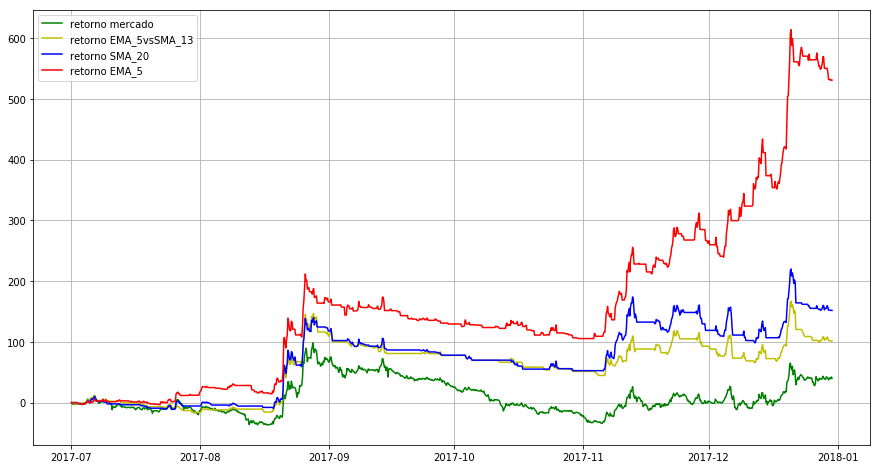

In [177]:
from strategy2 import EMAvsSMA,pricevsEMA, pricevsSMA
from profit import profit

#EMA_5vsSMA_13
w = EMAvsSMA(df['weightedAverage'],13,5)
wTrain = w[:int(len(df)*per)]
wTest = w[int(len(df)*per):]
relativeReturn,v = profit(wTrain)
relativeReturnTest,vTest = profit(wTest)

#Precio vs SMA_20
w3 = pricevsSMA(df['weightedAverage'],20)
w3Train = w3[:int(len(df)*per)]
w3Test = w3[int(len(df)*per):]
relativeReturn3,v3 = profit(w3Train)
relativeReturn3Test,v3Test = profit(w3Test)

#Precio vs EMA_5
# 23.6
w2 = pricevsEMA(df['weightedAverage'])
w2Train = w2[:int(len(df)*per)]
w2Test = w2[int(len(df)*per):]
relativeReturn2,v2 = profit(w2Train)
relativeReturn2Test,v2Test = profit(w2Test)

print 'Retorno del mercacdo: %s'%(marketReturn)
print 'Retorno de SMA13 VS EMA5: %s'%(relativeReturn*100)
print 'Retorno de Precio VS SMA20: %s'%(relativeReturn3*100)
print 'Retorno de Precio VS EMA5: %s'%(relativeReturn2*100)

plt.plot(df.index[:int(len(df)*per)],cum_return1*100,'g', label='retorno mercado')
plt.plot(df.index[:int(len(df)*per)],v*100,'y',label='retorno EMA_5vsSMA_13')
plt.plot(df.index[:int(len(df)*per)],v3*100,'b',label='retorno SMA_20')
plt.plot(df.index[:int(len(df)*per)],v2*100,'r',label='retorno EMA_5')

plt.legend(loc='best')
plt.grid()


## RSI via stockstacks

In [178]:
from stockstats import StockDataFrame

stock = StockDataFrame.retype(df.copy())
stock["rsi_14"];
stock["macd"];
stock["macds"];
stock["cci"];
stock["wr_14"];

In [179]:
from peakdetect import peakdetect

y = df['close'].values
x = df.index[:].values

_max, _min = peakdetect(y, x, 3)

xm = [p[0] for p in _max]
ym = [p[1] for p in _max]
xn = [p[0] for p in _min]
yn = [p[1] for p in _min]




## Indicadores via TA-Lib

In [180]:
#import talib

#df["fastk"], df["fastd"] = talib.STOCHRSI(df["close"].values, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)

#plt.subplot(211)
#plot = plt.plot(x, y)
#plt.hold(True)
#plt.plot(xm, ym, "r+")
#plt.plot(xn, yn, "g+")
#plt.subplot(212)
#df["fastk"].plot()
#df["fastd"].plot()

# Preparando DataFrame para ML

## Creando estrategia ideal en base a maximos y minimos

Retorno de estrategia ideal: 16063.309804


,cci,close,ideal_w,macd,macds,price,price_ema5,price_sma20,pricew,rsi,sma13ema5,volatility,volumen,wr
date,,,,,,,,,,,,,,
2017-12-29 23:00:00,-60.991025,0.024322,0.0,0.000096,0.000103,0.024322,0.0,0.0,0.023936,51.528844,0.0,True,164.998792,38.645424
2017-12-30 03:00:00,50.355924,0.024433,1.0,0.000102,0.000103,0.024433,1.0,1.0,0.024561,52.575320,0.0,False,188.688705,43.858925
2017-12-30 07:00:00,18.999271,0.024192,1.0,0.000086,0.000099,0.024192,1.0,1.0,0.024496,50.046765,0.0,False,221.203414,60.401482
2017-12-30 11:00:00,56.841066,0.024691,1.0,0.000112,0.000102,0.024691,1.0,1.0,0.024528,54.881107,1.0,True,166.848992,26.887609
2017-12-30 15:00:00,12.425699,0.024345,1.0,0.000104,0.000102,0.024345,1.0,1.0,0.024514,51.184980,1.0,False,139.267733,50.108055


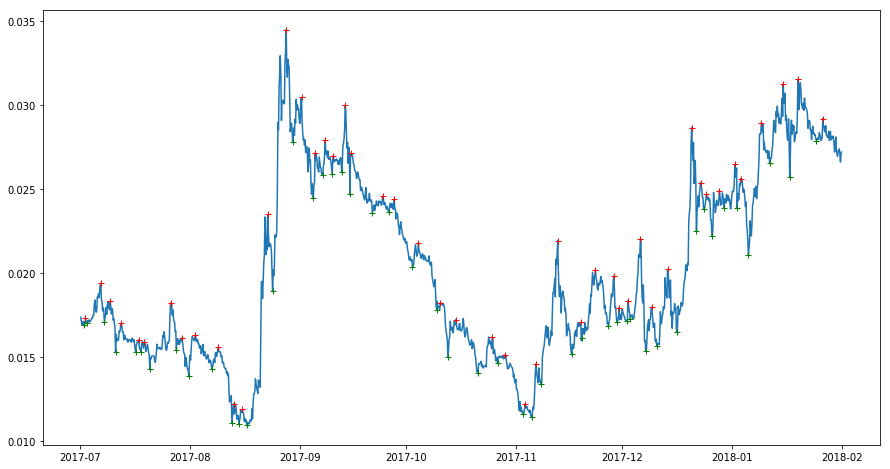

In [181]:
from mldata import ml_data
from orders import orders

df["ml_data"] = ml_data(df["close"],la=10)

w4 = pd.DataFrame(data={"w":df["ml_data"].values,"price":df["close"]})
w4["orders"] = orders(w4["w"])
w4["w"] = w4["w"].shift(1)
relReturn, vecReturn4 = profit(w4)
print "Retorno de estrategia ideal: %s"%(relReturn*100)

data = pd.DataFrame(data={"price":df["close"],"pricew":df["weightedAverage"],"volumen":df["volume"],
                          "rsi":stock["rsi_14"],"macd":stock["macd"],"macds":stock["macds"],"cci":stock["cci"],
                          "wr":stock["wr_14"] ,"sma13ema5":w["w"],"price_sma20":w3["w"],"price_ema5":w2["w"],
                          "ideal_w":w4["w"],"volatility": df["volatility"],"close":df["close"]})

# separando datos para crear y evaluar el modelo de machine learning
train = data[1:int(len(data)*per)]
test = data[int(len(data)*per):]
#train = data.loc["2014-09-10 00:00:00":"2017-06-01 00:00:00",:][1:]
#test = data.loc["2017-06-01 00:00:00":"2017-09-01 00:00:00",:]
train.tail()

# Creando modelo de regresion logistica utilizando sticklearn

In [182]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
# Estas dos últimas librerías permiten la creación de una 
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
# "price","volumen","rsi","macd","macds","sma13ema5","price_sma20","price_ema5","ideal_w","cci","diff","wr"
features = ["price","rsi","cci"]

# regresion logistica
logreg = LogisticRegression()

train.replace([np.inf, -np.inf], np.nan, inplace=True)
train.fillna(method='bfill', inplace=True)
# entrenando modelos
logreg.fit(train[features],train["ideal_w"])

C:\Users\Daniel.LAPTOP-OBVONK0N\Anaconda2\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [183]:
# random forests
random_forest = RandomForestClassifier(n_estimators=10)

random_forest.fit(train[features],train["ideal_w"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [184]:
# knn
knn = KNeighborsClassifier(n_neighbors = 30)

knn.fit(train[features],train["ideal_w"])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=30, p=2,
           weights='uniform')

In [190]:
# Neural network

# MLPClassifier

mlpc = MLPClassifier(solver='lbfgs',random_state=1, hidden_layer_sizes=(5, 2))

mlpc.fit(train[features],train["ideal_w"])

# BernoulliRBM

rbm = BernoulliRBM()
logistic = LogisticRegression()
classifier = Pipeline([("rbm",rbm),("logistic",logistic)])
classifier.fit(train[features],train["ideal_w"])

Pipeline(memory=None,
     steps=[('rbm', BernoulliRBM(batch_size=10, learning_rate=0.1, n_components=256, n_iter=10,
       random_state=None, verbose=0)), ('logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

## probando modelo en otros datos

Retorno del mercacdo: 11.5863709049
Retorno de SMA13 VS EMA5: 3.82225398238
Retorno de Precio VS SMA20: 17.2333760961
Retorno de Precio VS EMA5: 9.57495878677
Retorno de ML_logreg: 16.6094910604
Retorno de ML_randfor: -9.08964179799
Retorno de ML_knn: 1.79830877881
Retorno de ML_mlpc: 15.4862964921
Retorno de ML_Boltzman: 9.83255253483


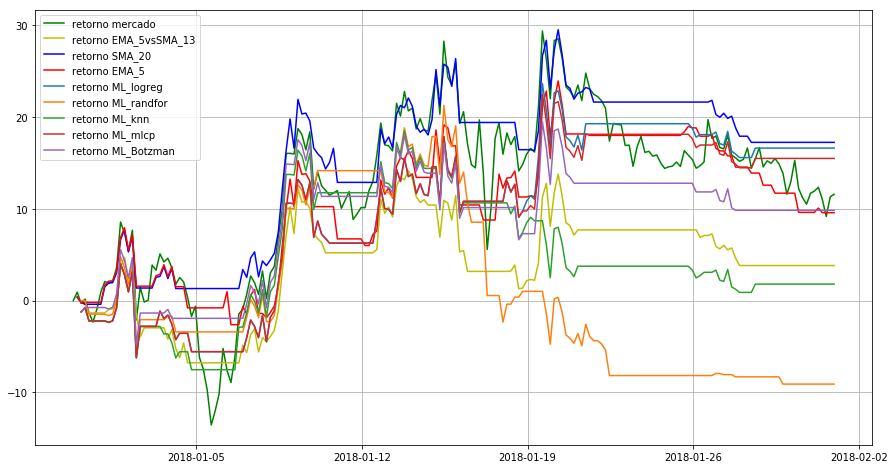

In [186]:
# regresion logistica
w_pred = logreg.predict(test[features])

w5 = pd.DataFrame(data={"w":w_pred,"price":test["close"]})
w5["orders"] = orders(w5["w"])
w5["w"] = w5["w"].shift(1)
relativeReturn5, v5 = profit(w5)

# random forest
w_pred2 = random_forest.predict(test[features])

w6 = pd.DataFrame(data={"w":w_pred2,"price":test["close"]})
w6["orders"] = orders(w6["w"])
w6["w"] = w6["w"].shift(1)
relativeReturn6, v6 = profit(w6)

# knn
w_pred3 = knn.predict(test[features])

w7 = pd.DataFrame(data={"w":w_pred3,"price":test["close"]})
w7["orders"] = orders(w7["w"])
w7["w"] = w7["w"].shift(1)
relativeReturn7, v7 = profit(w7)

# mlpc
w_pred4 = mlpc.predict(test[features])

w8 = pd.DataFrame(data={"w":w_pred4,"price":test["close"]})
w8["orders"] = orders(w8["w"])
w8["w"] = w8["w"].shift(1)
relativeReturn8, v8 = profit(w8)

# rbm
w_pred5 = classifier.predict(test[features])

w9 = pd.DataFrame(data={"w":w_pred5,"price":test["close"]})
w9["orders"] = orders(w9["w"])
w9["w"] = w9["w"].shift(1)
relativeReturn9, v9 = profit(w9)


print 'Retorno del mercacdo: %s'%(marketReturn2)
print 'Retorno de SMA13 VS EMA5: %s'%(relativeReturnTest*100)
print 'Retorno de Precio VS SMA20: %s'%(relativeReturn3Test*100)
print 'Retorno de Precio VS EMA5: %s'%(relativeReturn2Test*100)
print 'Retorno de ML_logreg: %s'%(relativeReturn5*100)
print 'Retorno de ML_randfor: %s'%(relativeReturn6*100)
print 'Retorno de ML_knn: %s'%(relativeReturn7*100)
print 'Retorno de ML_mlpc: %s'%(relativeReturn8*100)
print 'Retorno de ML_Boltzman: %s'%(relativeReturn9*100)

plt.plot(df.index[int(len(data)*per):],cum_return2*100,'g', label='retorno mercado')
plt.plot(df.index[int(len(data)*per):],vTest*100,'y',label='retorno EMA_5vsSMA_13')
plt.plot(df.index[int(len(data)*per):],v3Test*100,'b',label='retorno SMA_20')
plt.plot(df.index[int(len(data)*per):],v2Test*100,'r',label='retorno EMA_5')
plt.plot(df.index[int(len(data)*per):],v5*100,label='retorno ML_logreg')
plt.plot(df.index[int(len(data)*per):],v6*100,label='retorno ML_randfor')
plt.plot(df.index[int(len(data)*per):],v7*100,label='retorno ML_knn')
plt.plot(df.index[int(len(data)*per):],v8*100,label='retorno ML_mlcp')
plt.plot(df.index[int(len(data)*per):],v9*100,label='retorno ML_Botzman')

plt.legend(loc='best')
plt.grid()


In [187]:
w5.tail()

,price,w,orders,return
date,,,,
2018-01-31 07:00:00,0.027400,0.0,WAIT,0.166095
2018-01-31 11:00:00,0.027076,0.0,WAIT,0.166095
2018-01-31 15:00:00,0.026625,0.0,WAIT,0.166095
2018-01-31 19:00:00,0.027144,0.0,WAIT,0.166095
2018-01-31 23:00:00,0.027215,0.0,WAIT,0.166095


In [188]:
from strategy import ml_logreg

# Caracteristicas sobre las que se entrenara el modelo
feature_dic = {"rsi":stock["rsi_14"],"cci":stock["cci"],"price":df["close"]}

# Creando vector de pesos utilizando estrategia de ML de regresión logística
w_logreg = ml_logreg(df["close"],per=0.9,**feature_dic)

# Calculando retorno
relativeReturn6, v6 = profit(w_logreg)

print 'Retorno de ML_strategy: %s'%(relativeReturn6*100)

Retorno de ML_strategy: 0.151124911374


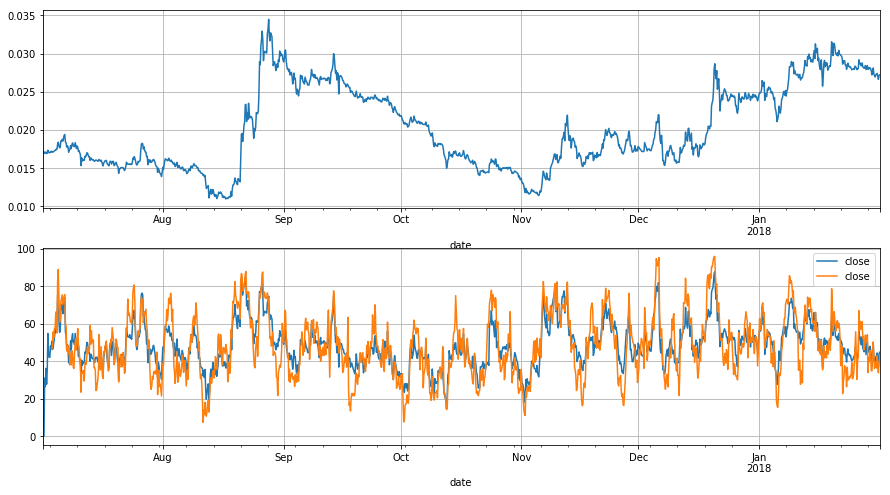

In [189]:
from indicators import rsi

RSI1, RSI2 = rsi(df["close"])

RSI1.head()

plt.subplot(211)
#plt.plot(df.index[1:],df['close'][1:],'r', label='precio')
plt.legend(loc='best')
df["close"].plot()
plt.grid()

plt.subplot(212)
RSI1.plot()
RSI2.plot()
plt.legend(loc='best')
plt.grid()